<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выбор модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>


# Отток клиентов банка


Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры (минимум 0.59).

Дополнительно нужно измерить *AUC-ROC* и сравнить ее значение с *F1*-мерой.

## 1. Описание данных

_Признаки:_

   * RowNumber — индекс строки в данных
   * CustomerId — уникальный идентификатор клиента
   * Surname — фамилия
   * CreditScore — кредитный рейтинг
   * Geography — страна проживания
   * Gender — пол
   * Age — возраст
   * Tenure — количество недвижимости у клиента
   * Balance — баланс на счёте
   * NumOfProducts — количество продуктов банка, используемых клиентом
   * HasCrCard — наличие кредитной карты
   * IsActiveMember — активность клиента
   * EstimatedSalary — предполагаемая зарплата

_Целевой признак:_

   * Exited — факт ухода клиента (1-клиент ушел; 0-клиент остался)

## 2. Подготовка данных

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from scipy.stats import uniform
from sklearn.utils import shuffle

try:
    table = pd.read_csv('/datasets/Churn.csv')
except:
    table = pd.read_csv('home/an4ouce/datasets/Churn.csv')

table.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
table.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видим, что есть пропуски в столбце Tenure (количество недвижимости у клиента). Хорошо бы знать, насколько важен этот признак, но узнать это мы сможем только после обучения модели, с помощью future_importances_. Удалять данные не хотелось бы, так как среди тех клиентов, у кого стоит пропуск в столбце Tenure, есть немало с интересующим нас целевым признаком (Exited=1). Посмотрим, какие имеются значения в столбце Tenure:

In [4]:
table['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Взглянем на распределение признака:

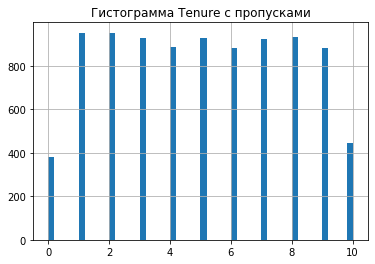

In [5]:
table['Tenure'].hist(bins=50)
plt.title('Гистограмма Tenure с пропусками')
plt.show()

In [6]:
table['Tenure'].mean()

4.997690023099769

Видно, что если мы заменим пропуски на среднее/медиану или на ноль, то сильно изменим распределение. Заполним пропуски в столбце Tenure случайным числом в диапазоне от минимума до максимума значений в столбце и посмотрим, как изменится распределение.

In [5]:
table.loc[table['Tenure'].isna(), 'Tenure'] = [random.randint(0, 10) for i in range(sum(table['Tenure'].isna()))]

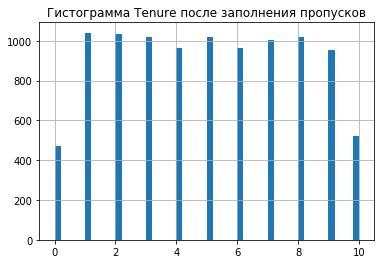

In [8]:
table['Tenure'].hist(bins=50)
plt.title('Гистограмма Tenure после заполнения пропусков')
plt.show()

Видим, что форма распределения не изменилась.

Согласно describe, есть аномалии в столбце EstimatedSalary - минимум 11.58 у.е. Взглянем на диаграмму размаха:

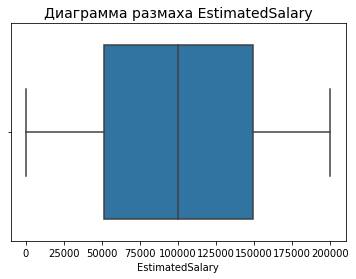

In [9]:
sns.boxplot(table['EstimatedSalary'])
plt.title('Диаграмма размаха EstimatedSalary', fontsize=14)
plt.show()

In [10]:
table.query('11.58 <= EstimatedSalary < 1000')['EstimatedSalary'].count()

59

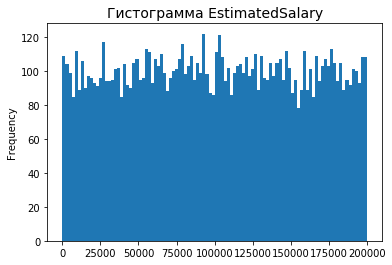

In [11]:
table['EstimatedSalary'].plot(kind='hist', bins=100)
plt.title('Гистограмма EstimatedSalary', fontsize=14)
plt.show()

Подозрительно странное распределение, возможно, данные созданы искусственно. Выбросов не наблюдается, у 59 клиентов зарплата до 1000 у.е. Столбец называется "предполагаемая зарплата", возможно, он сформирован по предсказаниям какой-нибудь модели. Оставим данные, как есть.

Проверим баланс классов:

In [12]:
table['Exited'].value_counts().to_frame()

,Exited
0,7963
1,2037


Больше значений '0' целевого признака, классы несбалансированы. Искомый целевой признак '1' (факт ухода клиента) приходится всего лишь на 20% данных.

Признаки RowNumber, CustomerId, Surname будут мешать обучению модели, так как уникальны для каждого клиента. Есть, конечно, однофамильцы, но фамилия человека не влияет на вероятность его ухода из банка. Удалим эти признаки:

In [6]:
table = table.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
table.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Рассмотрим признаки.

Категориальные признаки:
* Geography
* Gender
* HasCrCard
* IsActiveMember

Количественные признаки:
* CreditScore
* Age
* Tenure
* Balance
* NumOfProducts
* EstimatedSalary

Проверим дубликаты:

In [14]:
table.duplicated().sum()

0

Для удобства приведем названия столбцов к нижнему регистру:

In [7]:
table.columns = table.columns.str.lower()

Проверим признаки на мультиколлинеарность:

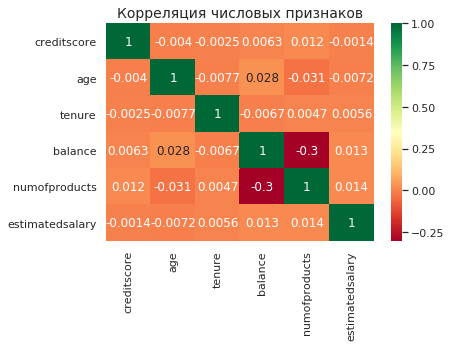

In [8]:
numeric = table.drop(['hascrcard', 'isactivemember', 'exited', 'geography', 'gender'], axis=1)
sns.set(font_scale=1)
sns.heatmap(numeric.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Мультиколлинеарность отсутствует, можно работать дальше.

Приведем данные в столбце tenure к целочисленному типу:

In [9]:
table['tenure'] = table['tenure'].astype('int')
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


**Вывод**: данные подготовлены, можно приступать к исследованию моделей.

## 3. Исследование задачи

Так как у нас имеются категориальные признаки с типом данных 'object' (geography, gender), модель не сможет с ними работать. Для кодировки таких признаков воспользуемся техникой OHE(One-hot encoding), так как она подходит для всех моделей.

In [10]:
table_ohe = pd.get_dummies(table, drop_first=True)
table_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
creditscore          10000 non-null int64
age                  10000 non-null int64
tenure               10000 non-null int64
balance              10000 non-null float64
numofproducts        10000 non-null int64
hascrcard            10000 non-null int64
isactivemember       10000 non-null int64
estimatedsalary      10000 non-null float64
exited               10000 non-null int64
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [11]:
target = table_ohe['exited']
features = table_ohe.drop('exited', axis = 1)

Разделим наши данные на обучающую, валидационную и тестовую выборки. Для тестовой выборки возьмем 20% данных.

In [12]:
features_common, features_test, target_common, target_test = train_test_split(features, target,
                                                                              test_size=0.2,
                                                                              random_state = 12345,
                                                                              stratify=target)

In [21]:
target_test.value_counts().to_frame()

,exited
0,1593
1,407


Теперь разделим оставшиеся данные на обучающую и валидационную выборки. Размер валидационной выборки - 20% данных.

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(features_common,
                                                                              target_common,
                                                                              test_size=0.25,
                                                                              random_state = 12345,
                                                                              stratify = target_common)

In [23]:
target_valid.value_counts().to_frame()

,exited
0,1593
1,407


Размер обучающей выборки:

In [24]:
target_train.value_counts().to_frame()

,exited
0,4777
1,1223


Некоторые числовые признаки имеют разный масштаб: 
* возраст - от 18 до 92 лет;
* кредитный рейтинг - от 350 до 850;
* сумма на балансе - от 0 до 251 000 у.е.;
* зарплата - от 11.58 до 200 000 у.е.

Если не привести данные к единому масштабу, модель будет думать, что самые важные признаки - сумма на балансе счета и зарплата клиента. Хотя важны все признаки. Произведем масштабирование:

In [14]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
5536,-0.143332,0.577533,2,-1.220573,2,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,2,0.435807,1,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,1,1.245822,1,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,5,-1.220573,1,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,1,1.421989,2,1,0,-1.361559,0,1,1


In [15]:
features_valid.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
9375,0.094161,0.862946,4,0.757050,2,1,0,-0.308325,1,0,1
9536,-1.031349,0.292120,10,0.838881,1,1,0,-0.645029,1,0,0
6344,2.066384,0.196983,3,-1.220573,2,1,0,0.498373,0,0,1
4357,1.085435,-0.278706,8,-1.220573,2,1,0,1.331035,0,0,1
9120,0.548495,1.814323,4,0.266421,1,0,1,-0.261760,0,1,1


Сначала обучим различные модели без учета дисбаланса классов, применив метод поиска оптимальных гиперпараметров RandomizedSearchCV.

### 3.1. Логистическая регрессия

In [26]:
model_regress = LogisticRegression(solver='liblinear', random_state=0)

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

rs_regress = RandomizedSearchCV(model_regress, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        random_state=0,
                        scoring='f1')
rs_regress.fit(features_train, target_train)
rs_regress.best_params_

{'C': 1.4729661593621919, 'penalty': 'l2'}

Получим предсказания модели и выведем сводный отчет о метриках accuracy, precision, recall, f1-score.

In [27]:
predictions_regress = rs_regress.predict(features_valid)

report_regress = classification_report(target_valid, predictions_regress, output_dict=True)
report_regress = pd.DataFrame(report_regress).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_regress)

              precision  recall  f1-score  support
0                  0.83    0.97      0.90  1593.00
1                  0.67    0.21      0.32   407.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.75    0.59      0.61  2000.00
weighted avg       0.80    0.82      0.78  2000.00


Accuracy получилось довольно большим, но как мы знаем, выборка несбалансирована, потому эта метрика в данном случае не говорит ни о чем. Полнота признака '1' низкая, значит, модель плохо разобралась в отличиях классов (объяснимо, ведь училась она в основном на нулях). Точность признака '1' выше, чем полнота. Значение F1 (среднее гармоническое полноты и точности) низкое. Модель никуда не годится.

Взглянем на матрицу ошибок:

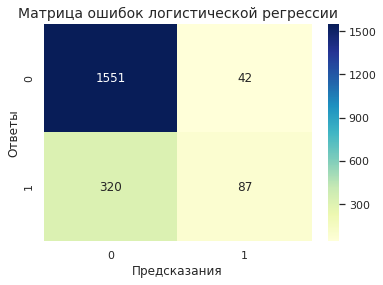

In [28]:
df_cm_regress = pd.DataFrame(confusion_matrix(target_valid, predictions_regress))
sns.set(font_scale=1)
sns.heatmap(df_cm_regress, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок логистической регрессии', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)

plt.show()

Модель хорошо определила отрицательный класс, но очень плохо разобралась с положительным. FN-значений много, то есть модель не смогла распознать ушедших клиентов, и это полный провал. Скорее всего, причина в несбалансированности классов.

### 3.2. Случайный лес

In [29]:
model_forest = RandomForestClassifier(random_state=0)
                                     
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest = RandomizedSearchCV(model_forest,
                               param_dist,
                               n_iter = 100,
                               cv = 3,
                               verbose = 0, 
                               n_jobs= 1, 
                               random_state=0,
                               scoring = 'f1')

rs_forest.fit(features_train, target_train)
rs_forest.best_params_                                

{'n_estimators': 20,
 'min_samples_split': 23,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 14,
 'criterion': 'entropy'}

Получим предсказания модели случайного леса и выведем сводный отчет о метриках accuracy, precision, recall, f1-score.

In [30]:
predictions_forest = rs_forest.predict(features_valid)

report_forest = classification_report(target_valid, predictions_forest, output_dict=True)
report_forest = pd.DataFrame(report_forest).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_forest)

              precision  recall  f1-score  support
0                  0.87    0.97      0.92  1593.00
1                  0.80    0.45      0.57   407.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.84    0.71      0.75  2000.00
weighted avg       0.86    0.86      0.85  2000.00


Эта модель определенно лучше. Все метрики (точность, полнота, F1-мера) выше, чем у логистической регрессии.

Взглянем на матрицу ошибок:

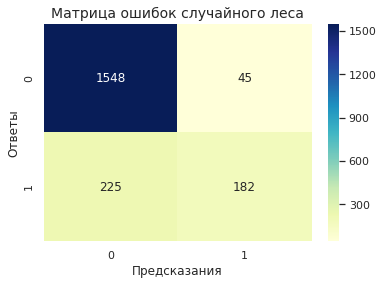

In [31]:
df_cm_forest = pd.DataFrame(confusion_matrix(target_valid, predictions_forest))
sns.set(font_scale=1)
sns.heatmap(df_cm_forest, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок случайного леса', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Модель хорошо определила отрицательный класс, и получше, чем предыдущая модель, разобралась с положительным. И все равно FN-значений довольно много, модель тоже плохо распознает ушедших клиентов.

### 3.3. Решающее дерево

In [32]:
model_tree = DecisionTreeClassifier(random_state=0)
                                     
max_features = ['sqrt', 'log2']
splitter = ['best', 'random']
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]

param_dist = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'splitter': splitter}

rs_tree = RandomizedSearchCV(model_tree, 
                        param_dist,  
                        cv = 5,
                        n_iter=100,
                        verbose = 0, 
                        n_jobs=1,
                        scoring='f1',
                        random_state=0)

rs_tree.fit(features_train, target_train)
rs_tree.best_params_                                

{'splitter': 'best',
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini'}

Получим предсказания модели решающего дерева и выведем сводный отчет о метриках accuracy, precision, recall, f1-score.

In [33]:
predictions_tree = rs_tree.predict(features_valid)

report_tree = classification_report(target_valid, predictions_tree, output_dict=True)
report_tree = pd.DataFrame(report_tree).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_tree)

              precision  recall  f1-score  support
0                  0.86    0.95      0.90  1593.00
1                  0.66    0.37      0.47   407.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.76    0.66      0.69  2000.00
weighted avg       0.82    0.83      0.81  2000.00


У этой модели метрика F1 ниже, чем у случайного леса, но работает модель быстрее всех.

Взглянем на матрицу ошибок:

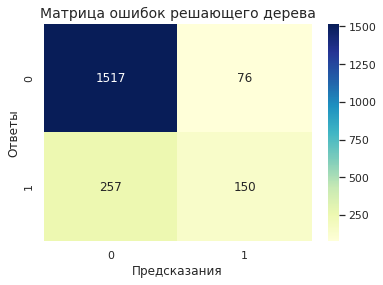

In [34]:
df_cm_tree = pd.DataFrame(confusion_matrix(target_valid, predictions_tree))
sns.set(font_scale=1)
sns.heatmap(df_cm_tree, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок решающего дерева', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Модель все также переусердсвует с FN.

Построим ROC-кривые всех исследованных моделей и посчитаем метрику AUC-ROC.

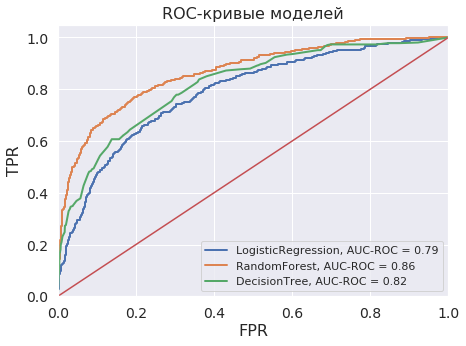

In [35]:
fpr1, tpr1, thresholds1 = roc_curve(target_valid, rs_regress.predict_proba(features_valid)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_valid, rs_forest.predict_proba(features_valid)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_valid, rs_tree.predict_proba(features_valid)[:,1], pos_label=1)

auc_regress = roc_auc_score(target_valid, rs_regress.predict_proba(features_valid)[:,1])
auc_forest = roc_auc_score(target_valid, rs_forest.predict_proba(features_valid)[:,1])
auc_tree = roc_auc_score(target_valid, rs_tree.predict_proba(features_valid)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress)
ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForest, AUC-ROC = %.2f' %auc_forest)
ax.plot(fpr3, tpr3, lw=lw, label= 'DecisionTree, AUC-ROC = %.2f' %auc_tree)

plt.title('ROC-кривые моделей', fontsize=16)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

В лидерах случайный лес. Сделаем сводный отчет метрик всех трех моделей.

In [36]:
data = {'accuracy':[report_regress.loc['accuracy', 'support'], report_forest.loc['accuracy', 'support'], report_tree.loc['accuracy', 'support']],
        'precision':[report_regress.loc['1', 'precision'], report_forest.loc['1', 'precision'], report_tree.loc['1', 'precision']],
        'recall':[report_regress.loc['1', 'recall'], report_forest.loc['1', 'recall'], report_tree.loc['1', 'recall']],
        'F1':[report_regress.loc['1', 'f1-score'], report_forest.loc['1', 'f1-score'], report_tree.loc['1', 'f1-score']],
       'AUC-ROC': [auc_regress, auc_forest, auc_tree]}

table_compare = pd.DataFrame(data)
pd.set_option('display.float_format', '{:.2f}'.format)
table_compare.index = ['Логистическая регрессия', 'Случайный лес', 'Решающее дерево']
print(table_compare)

                         accuracy  precision  recall   F1  AUC-ROC
Логистическая регрессия      0.82       0.67    0.21 0.32     0.79
Случайный лес                0.86       0.80    0.45 0.57     0.86
Решающее дерево              0.83       0.66    0.37 0.47     0.82


По итогам исследования можно сказать следующее.

Мы имели дело с сильным дисбалансом классов (80/20), что сыграло свою роль в обучении моделей.
Из всех рассмотренных моделей лучшая - случайный лес, все метрики у нее самые высокие. Но эта модель пока не решает поставленную задачу, путается в классах. Необходимо сбалансировать классы и сравнить результаты.

Визуализируем важность признаков на примере лучшей модели:

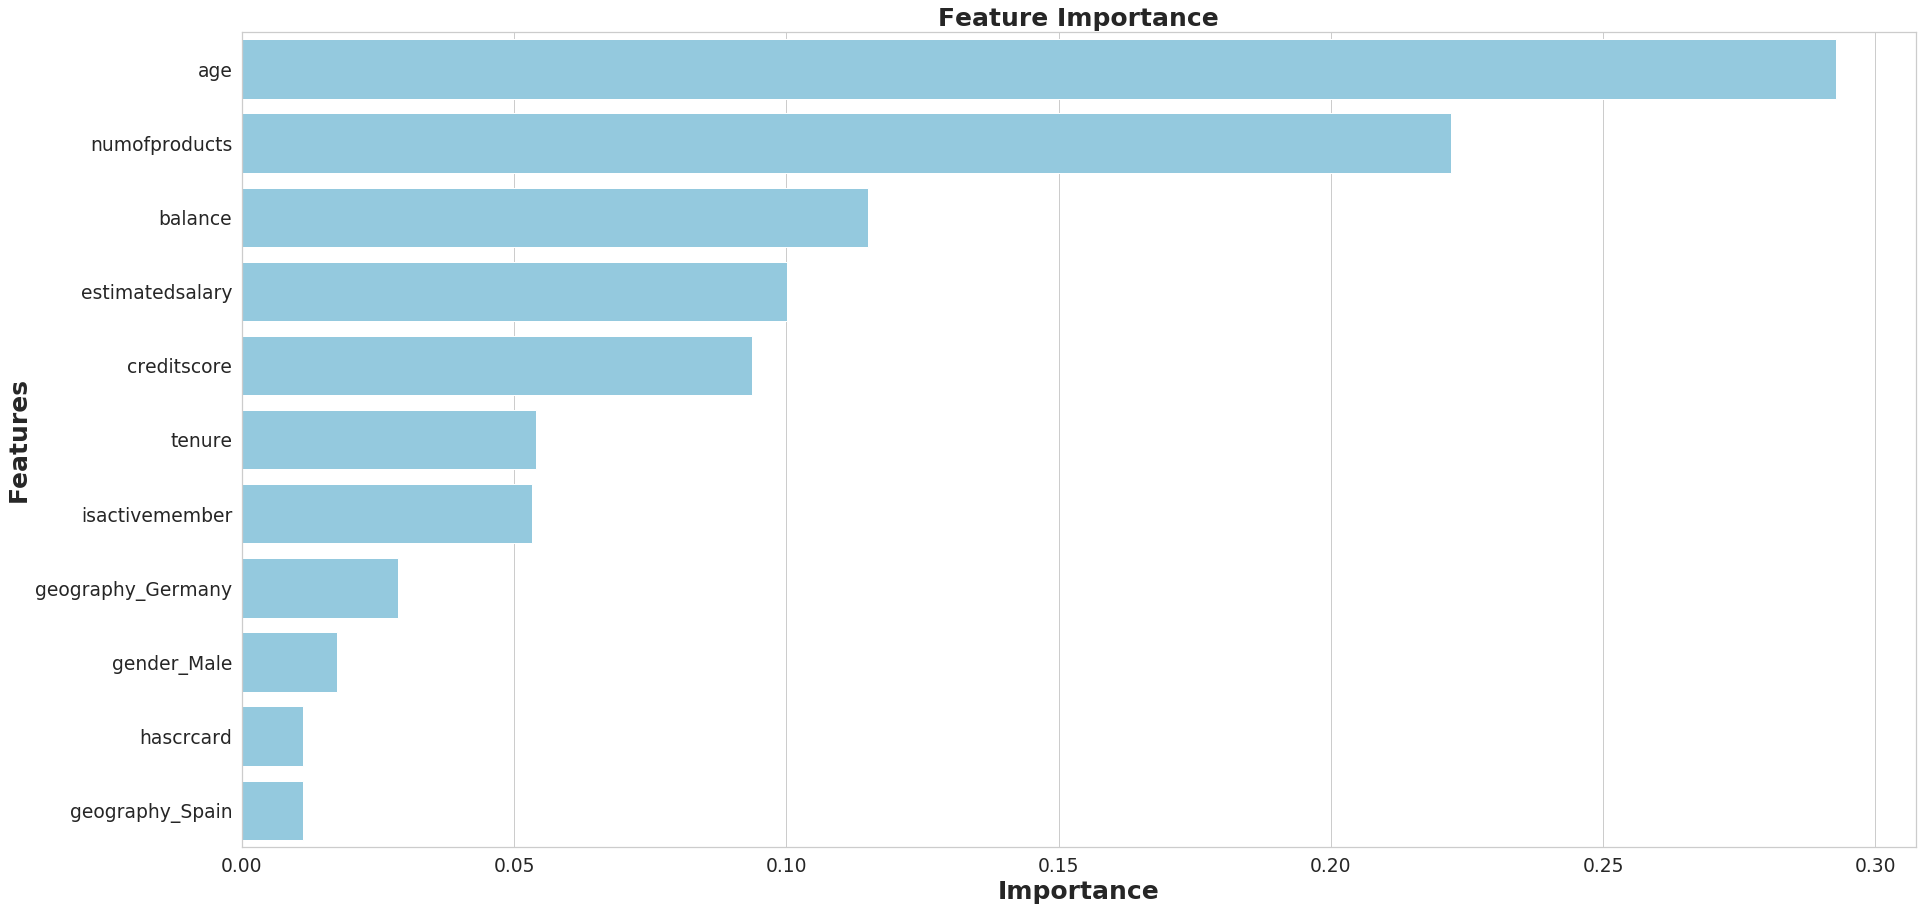

In [37]:
top_params = rs_forest.best_params_
model_forest = RandomForestClassifier(n_estimators = top_params['n_estimators'],
                                     min_samples_split = top_params['min_samples_split'],
                                     min_samples_leaf = top_params['min_samples_leaf'],
                                     max_features = top_params['max_features'],
                                     max_depth = top_params['max_depth'],
                                     criterion = top_params['criterion'])
model_forest.fit(features_train, target_train)
feats = {}
for feature, importance in zip(features.columns, model_forest.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Как видно, самый важный признак - возраст клиента. За ним следуют: количество банковских продуктов, сумма на балансе счета, кредитный рейтинг, предполагаемая зарплата. Количество недвижимости у клиента не в топе признаков.

**Вывод:** мы исследовали модели без учета дисбаланса классов, потому все модели показали не лучшие результаты - хорошо предсказывают отрицательный класс, но плохо - положительный. Из всех рассмотренных моделей лучшая - случайный лес, но и она не решает поставленную задачу. Далее рассмотрим несколько способов борьбы с дисбалансом, результаты должны улучшиться.

## 4. Борьба с дисбалансом

Применим следующие способы борьбы с дисбалансом: взвешивание классов, увеличение выборки, уменьшение выборки.

### 4.1. Взвешивание классов

Для каждой модели добавим параметр class_weight = 'balanced' и выполним переобучение.

### 4.1.1. Логистическая регрессия при взвешивании классов

In [38]:
model_regress_balanced = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=0)

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

rs_regress_balanced = RandomizedSearchCV(model_regress_balanced, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs= 1,
                        random_state=0,
                        scoring='f1')

rs_regress_balanced.fit(features_train, target_train)
rs_regress_balanced.best_params_

{'C': 0.018781904770188262, 'penalty': 'l2'}

Составим отчет о метриках:

In [39]:
predictions_regress_balanced = rs_regress_balanced.predict(features_valid)

report_regress_balanced = classification_report(target_valid, predictions_regress_balanced, output_dict=True)
report_regress_balanced = pd.DataFrame(report_regress_balanced).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_regress_balanced)

              precision  recall  f1-score  support
0                  0.91    0.73      0.81  1593.00
1                  0.41    0.72      0.52   407.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.66    0.73      0.67  2000.00
weighted avg       0.81    0.73      0.75  2000.00


Взглянем на матрицу ошибок:

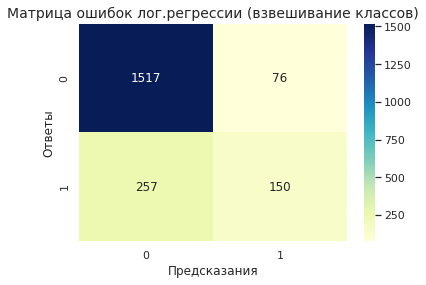

In [40]:
df_cm_regress = pd.DataFrame(confusion_matrix(target_valid, predictions_tree))
sns.set(font_scale=1)
sns.heatmap(df_cm_regress, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок лог.регрессии (взвешивание классов)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

У логистической регрессии метрика F1 значительно увеличилась. Модель стала луше предсказывать положительный класс, но переусердствует в присвоении FN. Точность снизилась.

### 4.1.2. Случайный лес при взвешивании классов

In [41]:
model_forest_balanced = RandomForestClassifier(random_state=0, class_weight='balanced')
                                     
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest_balanced = RandomizedSearchCV(model_forest_balanced,
                               param_dist,
                               n_iter = 100,
                               cv = 3,
                               verbose = 0, 
                               n_jobs= 1, 
                               random_state=0,
                               scoring = 'f1')

rs_forest_balanced.fit(features_train, target_train)
rs_forest_balanced.best_params_                                

{'n_estimators': 35,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 13,
 'criterion': 'entropy'}

Получим отчет о метриках:

In [42]:
predictions_forest_balanced = rs_forest_balanced.predict(features_valid)

report_forest_balanced = classification_report(target_valid, predictions_forest_balanced, output_dict=True)
report_forest_balanced = pd.DataFrame(report_forest_balanced).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_forest_balanced)

              precision  recall  f1-score  support
0                  0.91    0.90      0.91  1593.00
1                  0.63    0.66      0.64   407.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.77    0.78      0.77  2000.00
weighted avg       0.85    0.85      0.85  2000.00


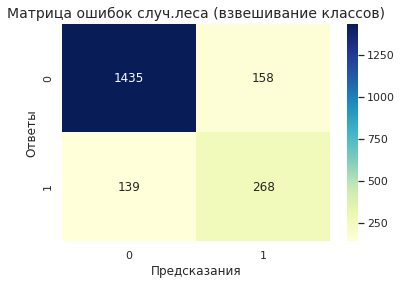

In [43]:
df_cm_forest_balanced = pd.DataFrame(confusion_matrix(target_valid, predictions_forest_balanced))
sns.set(font_scale=1)
sns.heatmap(df_cm_forest_balanced, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок случ.леса (взвешивание классов)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Неплохой результат. Метрика F1 увеличилась. Модель стала лучше стала предсказывать положительный класс, но не без ошибок. Увеличилась полнота, но снизилась точность.

### 4.1.3. Решающее дерево при взвешивании классов

In [44]:
model_tree_balanced = DecisionTreeClassifier(random_state=0, class_weight='balanced')
                                     
max_features = ['sqrt', 'log2']
splitter = ['best', 'random']
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]

param_dist = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'splitter': splitter}

rs_tree_balanced = RandomizedSearchCV(model_tree_balanced, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 0, 
                        n_jobs= 1, 
                        random_state=0,
                        scoring = 'f1')

rs_tree_balanced.fit(features_train, target_train)
rs_tree_balanced.best_params_                                

{'splitter': 'random',
 'min_samples_split': 2,
 'min_samples_leaf': 11,
 'max_features': 'sqrt',
 'max_depth': 5,
 'criterion': 'gini'}

In [45]:
predictions_tree_balanced = rs_tree_balanced.predict(features_valid)

report_tree_balanced = classification_report(target_valid, predictions_tree_balanced, output_dict=True)
report_tree_balanced = pd.DataFrame(report_tree_balanced).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_tree_balanced)

              precision  recall  f1-score  support
0                  0.90    0.79      0.84  1593.00
1                  0.45    0.67      0.54   407.00
accuracy           0.77    0.77      0.77     0.77
macro avg          0.68    0.73      0.69  2000.00
weighted avg       0.81    0.77      0.78  2000.00


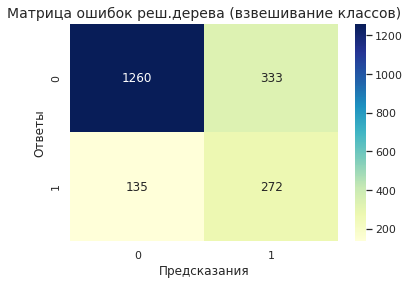

In [46]:
df_cm_tree_balanced = pd.DataFrame(confusion_matrix(target_valid, predictions_tree_balanced))
sns.set(font_scale=1)
sns.heatmap(df_cm_tree_balanced, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок реш.дерева (взвешивание классов)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

У решающего дерева метрика F1 увеличилась, но теперь модель стала переусердствовать в присвоении FP. Увеличилась полнота, но снизилась точность.

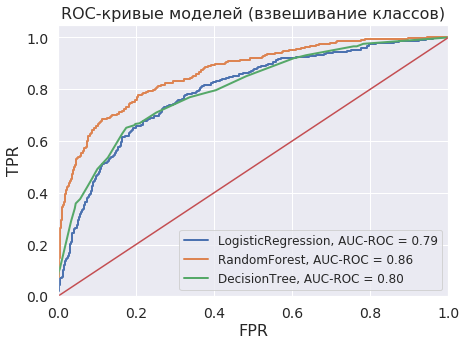

In [47]:
fpr1, tpr1, thresholds1 = roc_curve(target_valid, rs_regress_balanced.predict_proba(features_valid)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_valid, rs_forest_balanced.predict_proba(features_valid)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_valid, rs_tree_balanced.predict_proba(features_valid)[:,1], pos_label=1)

auc_regress_balanced = roc_auc_score(target_valid, rs_regress_balanced.predict_proba(features_valid)[:,1])
auc_forest_balanced = roc_auc_score(target_valid, rs_forest_balanced.predict_proba(features_valid)[:,1])
auc_tree_balanced = roc_auc_score(target_valid, rs_tree_balanced.predict_proba(features_valid)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress_balanced)
ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForest, AUC-ROC = %.2f' %auc_forest_balanced)
ax.plot(fpr3, tpr3, lw=lw, label= 'DecisionTree, AUC-ROC = %.2f' %auc_tree_balanced)

plt.title('ROC-кривые моделей (взвешивание классов)', fontsize=16)
plt.legend(loc='lower right', prop={'size':12})
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

И снова в лидерах - случайный лес.

Составим сводный отчет метрик моделей после взвешивания классов.

In [48]:
data = {'accuracy':[report_regress_balanced.loc['accuracy', 'support'], report_forest_balanced.loc['accuracy', 'support'], report_tree_balanced.loc['accuracy', 'support']],
        'precision':[report_regress_balanced.loc['1', 'precision'], report_forest_balanced.loc['1', 'precision'], report_tree_balanced.loc['1', 'precision']],
        'recall':[report_regress_balanced.loc['1', 'recall'], report_forest_balanced.loc['1', 'recall'], report_tree_balanced.loc['1', 'recall']],
        'F1':[report_regress_balanced.loc['1', 'f1-score'], report_forest_balanced.loc['1', 'f1-score'], report_tree_balanced.loc['1', 'f1-score']],
       'AUC-ROC': [auc_regress_balanced, auc_forest_balanced, auc_tree_balanced]}

table_compare = pd.DataFrame(data)

table_compare.index = ['Логистическая регрессия', 'Случайный лес', 'Решающее дерево']
print(table_compare)

                         accuracy  precision  recall   F1  AUC-ROC
Логистическая регрессия      0.73       0.41    0.72 0.52     0.79
Случайный лес                0.85       0.63    0.66 0.64     0.86
Решающее дерево              0.77       0.45    0.67 0.54     0.80


По совокупности метрик лучшим снова получается случайный лес. 

Теперь применим методы увеличения и уменьшения выборок.

### 4.2. Увеличение выборки

Для увеличения выборки воспользуемся техникой Upsampling: разделим обучающую выборку на положительные и отрицательные объекты, несколько раз скопируем положительные объекты, создадим новую выборку с учетом скопированных данных и выполним перемешивание.

In [49]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Целевой признак до увеличения выборки:

In [50]:
target_train.value_counts()

0    4777
1    1223
Name: exited, dtype: int64

Целевой признак после увеличения выборки:

In [51]:
target_upsampled.value_counts()

1    4892
0    4777
Name: exited, dtype: int64

### 4.2.1. Логистическая регрессия при увеличении выборки

In [52]:
model_regress_up = LogisticRegression(solver='liblinear', random_state=0)

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

rs_regress_up = RandomizedSearchCV(model_regress_up, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs= 1,
                        random_state=0,
                        scoring='f1')
rs_regress_up.fit(features_upsampled, target_upsampled)
rs_regress_up.best_params_

{'C': 0.018781904770188262, 'penalty': 'l2'}

In [53]:
predictions_regress_up = rs_regress_up.predict(features_valid)

report_regress_up = classification_report(target_valid, predictions_regress_up, output_dict=True)
report_regress_up = pd.DataFrame(report_regress_up).transpose()
pd.set_option('display.float_format', '{:.2f}'.format)
print(report_regress_up)

              precision  recall  f1-score  support
0                  0.91    0.72      0.80  1593.00
1                  0.40    0.73      0.52   407.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.66    0.73      0.66  2000.00
weighted avg       0.81    0.72      0.74  2000.00


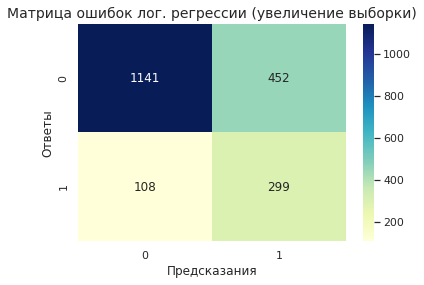

In [54]:
df_cm_regress_up = pd.DataFrame(confusion_matrix(target_valid, predictions_regress_up))
sns.set(font_scale=1)
sns.heatmap(df_cm_regress_up, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок лог. регрессии (увеличение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

При увеличении выборки логистическая регрессия стала очень много клиентов записывать в уходящие.

### 4.2.2. Случайный лес при увеличении выборки

In [55]:
model_forest_up = RandomForestClassifier(random_state=0)
                                     
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest_up = RandomizedSearchCV(model_forest_up,
                               param_dist,
                               n_iter = 100,
                               cv = 3,
                               verbose = 0, 
                               n_jobs= 1, 
                               random_state=0,
                               scoring='f1')

rs_forest_up.fit(features_upsampled, target_upsampled)
rs_forest_up.best_params_

{'n_estimators': 35,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 13,
 'criterion': 'entropy'}

In [56]:
predictions_forest_up = rs_forest_up.predict(features_valid)

report_forest_up = classification_report(target_valid, predictions_forest_up, output_dict=True)
report_forest_up = pd.DataFrame(report_forest_up).transpose()

print(report_forest_up)

              precision  recall  f1-score  support
0                  0.91    0.88      0.90  1593.00
1                  0.59    0.68      0.63   407.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.75    0.78      0.76  2000.00
weighted avg       0.85    0.84      0.84  2000.00


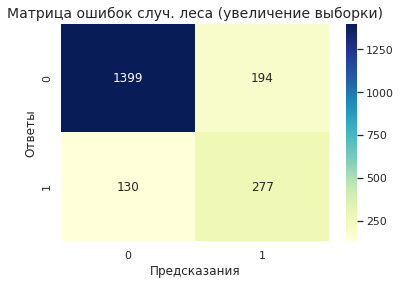

In [57]:
df_cm_forest_up = pd.DataFrame(confusion_matrix(target_valid, predictions_forest_up))
sns.set(font_scale=1)
sns.heatmap(df_cm_forest_up, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок случ. леса (увеличение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Случайный лес немного полуше разобрался в данных, но все-таки много клиентов записывает в уходящие.

### 4.2.3. Решающее дерево при увеличении выборки

In [58]:
model_tree_up = DecisionTreeClassifier(random_state=0)
                                     
max_features = ['sqrt', 'log2']
splitter = ['best', 'random']
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]

param_dist = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'splitter': splitter}

rs_tree_up = RandomizedSearchCV(model_tree_up, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 0, 
                        n_jobs= 1, 
                        random_state=0,
                        scoring='f1')

rs_tree_up.fit(features_upsampled, target_upsampled)
rs_tree_up.best_params_                                

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini'}

In [59]:
predictions_tree_up = rs_tree_up.predict(features_valid)

report_tree_up = classification_report(target_valid, predictions_tree_up, output_dict=True)
report_tree_up = pd.DataFrame(report_tree_up).transpose()

print(report_tree_up)

              precision  recall  f1-score  support
0                  0.91    0.77      0.83  1593.00
1                  0.43    0.70      0.53   407.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.67    0.73      0.68  2000.00
weighted avg       0.81    0.75      0.77  2000.00


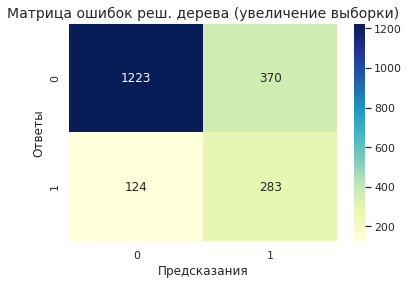

In [60]:
df_cm_tree_up = pd.DataFrame(confusion_matrix(target_valid, predictions_tree_up))
sns.set(font_scale=1)
sns.heatmap(df_cm_tree_up, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок реш. дерева (увеличение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

У решающего дерева при увеличении выборки также выпосла доля FP.

Взглянем на ROC-кривые и посчитаем метрику ROC-AUC:

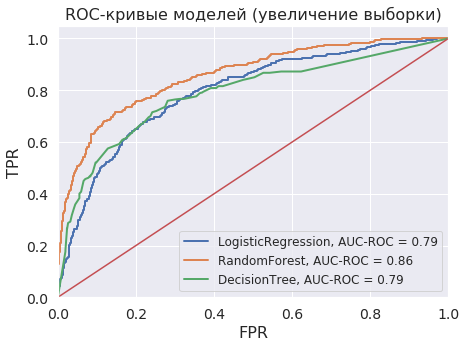

In [61]:
fpr1, tpr1, thresholds1 = roc_curve(target_valid, rs_regress_up.predict_proba(features_valid)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_valid, rs_forest_up.predict_proba(features_valid)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_valid, rs_tree_up.predict_proba(features_valid)[:,1], pos_label=1)

auc_regress_up = roc_auc_score(target_valid, rs_regress_up.predict_proba(features_valid)[:,1])
auc_forest_up = roc_auc_score(target_valid, rs_forest_up.predict_proba(features_valid)[:,1])
auc_tree_up = roc_auc_score(target_valid, rs_tree_up.predict_proba(features_valid)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress_up)
ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForest, AUC-ROC = %.2f' %auc_forest_up)
ax.plot(fpr3, tpr3, lw=lw, label= 'DecisionTree, AUC-ROC = %.2f' %auc_tree_up)

plt.title('ROC-кривые моделей (увеличение выборки)', fontsize=16)
plt.legend(loc='lower right', prop={'size':12})
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

In [62]:
data = {'accuracy':[report_regress_up.loc['accuracy', 'support'], report_forest_up.loc['accuracy', 'support'], report_tree_up.loc['accuracy', 'support']],
        'precision':[report_regress_up.loc['1', 'precision'], report_forest_up.loc['1', 'precision'], report_tree_up.loc['1', 'precision']],
        'recall':[report_regress_up.loc['1', 'recall'], report_forest_up.loc['1', 'recall'], report_tree_up.loc['1', 'recall']],
        'F1':[report_regress_up.loc['1', 'f1-score'], report_forest_up.loc['1', 'f1-score'], report_tree_up.loc['1', 'f1-score']],
       'AUC-ROC': [auc_regress_up, auc_forest_up, auc_tree_up]}

table_compare = pd.DataFrame(data)

table_compare.index = ['Логистическая регрессия', 'Случайный лес', 'Решающее дерево']
print(table_compare)

                         accuracy  precision  recall   F1  AUC-ROC
Логистическая регрессия      0.72       0.40    0.73 0.52     0.79
Случайный лес                0.84       0.59    0.68 0.63     0.86
Решающее дерево              0.75       0.43    0.70 0.53     0.79


И снова по совокупности метрик побеждает случайный лес.

### 4.3. Уменьшение выборки

Воспользуемся методом уменьшения выборки Downsampling: разделим обучающую выборку на положительные и отрицательные объекты, случайным образом отбросим часть отрицательных объектов, создадим новую обучающую выборку и выполним перемешивание.

In [63]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.27)

Целевой признак до уменьшения выборки:

In [64]:
target_train.value_counts()

0    4777
1    1223
Name: exited, dtype: int64

Целевой признак после уменьшения выборки:

In [65]:
target_downsampled.value_counts()

0    1290
1    1223
Name: exited, dtype: int64

### 4.3.1. Логистическая регрессия при уменьшении выборки

In [66]:
model_regress_down = LogisticRegression(solver='liblinear', random_state=0)

penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

rs_regress_down = RandomizedSearchCV(model_regress_down, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs= 1,
                        random_state=0,
                        scoring='f1')

rs_regress_down.fit(features_downsampled, target_downsampled)
rs_regress_down.best_params_

{'C': 0.1345003739953281, 'penalty': 'l1'}

In [67]:
predictions_regress_down = rs_regress_down.predict(features_valid)

report_regress_down = classification_report(target_valid, predictions_regress_down, output_dict=True)
report_regress_down = pd.DataFrame(report_regress_down).transpose()

print(report_regress_down)

              precision  recall  f1-score  support
0                  0.91    0.74      0.81  1593.00
1                  0.41    0.70      0.51   407.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.66    0.72      0.66  2000.00
weighted avg       0.80    0.73      0.75  2000.00


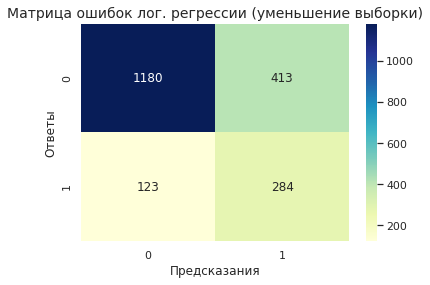

In [68]:
df_cm_regress_down = pd.DataFrame(confusion_matrix(target_valid, predictions_regress_down))
sns.set(font_scale=1)
sns.heatmap(df_cm_regress_down, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок лог. регрессии (уменьшение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Логистическая регрессия стала меньше ошибаться, доля FP стала меньше. Но до решения поставленной задачи далеко.

### 4.3.2. Случайный лес при уменьшении выборки

In [69]:
model_forest_down = RandomForestClassifier(random_state=0)
                                     
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest_down = RandomizedSearchCV(model_forest_down,
                               param_dist,
                               n_iter = 100,
                               cv = 3,
                               verbose = 0, 
                               n_jobs= 1, 
                               random_state=0,
                               scoring='f1')

rs_forest_down.fit(features_downsampled, target_downsampled)
rs_forest_down.best_params_

{'n_estimators': 30,
 'min_samples_split': 23,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15,
 'criterion': 'entropy'}

In [70]:
predictions_forest_down = rs_forest_down.predict(features_valid)

report_forest_down = classification_report(target_valid, predictions_forest_down, output_dict=True)
report_forest_down = pd.DataFrame(report_forest_down).transpose()

print(report_forest_down)

              precision  recall  f1-score  support
0                  0.93    0.82      0.87  1593.00
1                  0.52    0.76      0.62   407.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.72    0.79      0.74  2000.00
weighted avg       0.85    0.81      0.82  2000.00


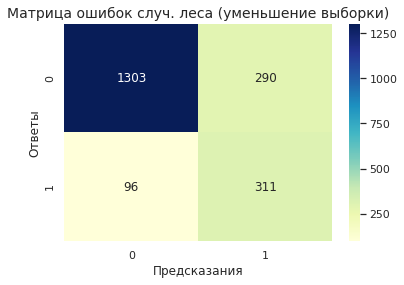

In [71]:
df_cm_forest_down = pd.DataFrame(confusion_matrix(target_valid, predictions_forest_down))
sns.set(font_scale=1)
sns.heatmap(df_cm_forest_down, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок случ. леса (уменьшение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Уменьшение выборки увеличило полноту случайного леса, потому модель стала больше присваивать FP.

### 4.3.3. Решающее дерево при уменьшении выборки

In [72]:
model_tree_down = DecisionTreeClassifier(random_state=0)
                                     
max_features = ['sqrt', 'log2']
splitter = ['best', 'random']
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]

param_dist = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'splitter': splitter}

rs_tree_down = RandomizedSearchCV(model_tree_down, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 0, 
                        n_jobs= 1,
                        random_state=0,
                        scoring='f1')

rs_tree_down.fit(features_downsampled, target_downsampled)
rs_tree_down.best_params_                                

{'splitter': 'best',
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 7,
 'criterion': 'entropy'}

In [73]:
predictions_tree_down = rs_tree_down.predict(features_valid)

report_tree_down = classification_report(target_valid, predictions_tree_down, output_dict=True)
report_tree_down = pd.DataFrame(report_tree_down).transpose()

print(report_tree_down)

              precision  recall  f1-score  support
0                  0.92    0.74      0.82  1593.00
1                  0.43    0.74      0.54   407.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.67    0.74      0.68  2000.00
weighted avg       0.82    0.74      0.77  2000.00


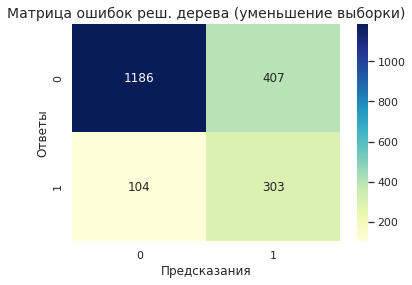

In [74]:
df_cm_tree_down = pd.DataFrame(confusion_matrix(target_valid, predictions_tree_down))
sns.set(font_scale=1)
sns.heatmap(df_cm_tree_down, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок реш. дерева (уменьшение выборки)', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

И снова сыграла роль увеличенная полнота - много FP. Взглянем на ROC-кривые:

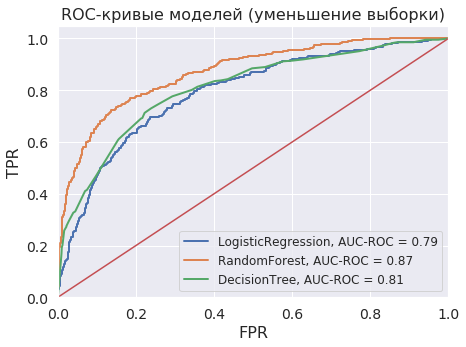

In [75]:
fpr1, tpr1, thresholds1 = roc_curve(target_valid, rs_regress_down.predict_proba(features_valid)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_valid, rs_forest_down.predict_proba(features_valid)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_valid, rs_tree_down.predict_proba(features_valid)[:,1], pos_label=1)

auc_regress_down = roc_auc_score(target_valid, rs_regress_down.predict_proba(features_valid)[:,1])
auc_forest_down = roc_auc_score(target_valid, rs_forest_down.predict_proba(features_valid)[:,1])
auc_tree_down = roc_auc_score(target_valid, rs_tree_down.predict_proba(features_valid)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress_down)
ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForest, AUC-ROC = %.2f' %auc_forest_down)
ax.plot(fpr3, tpr3, lw=lw, label= 'DecisionTree, AUC-ROC = %.2f' %auc_tree_down)

plt.title('ROC-кривые моделей (уменьшение выборки)', fontsize=16)
plt.legend(loc='lower right', prop={'size':12})
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

In [76]:
data = {'accuracy':[report_regress_down.loc['accuracy', 'support'], report_forest_down.loc['accuracy', 'support'], report_tree_down.loc['accuracy', 'support']],
        'precision':[report_regress_down.loc['1', 'precision'], report_forest_down.loc['1', 'precision'], report_tree_down.loc['1', 'precision']],
        'recall':[report_regress_down.loc['1', 'recall'], report_forest_down.loc['1', 'recall'], report_tree_down.loc['1', 'recall']],
        'F1':[report_regress_down.loc['1', 'f1-score'], report_forest_down.loc['1', 'f1-score'], report_tree_down.loc['1', 'f1-score']]}

table_compare = pd.DataFrame(data)

table_compare.index = ['Логистическая регрессия', 'Случайный лес', 'Решающее дерево']
print(table_compare)

                         accuracy  precision  recall   F1
Логистическая регрессия      0.73       0.41    0.70 0.51
Случайный лес                0.81       0.52    0.76 0.62
Решающее дерево              0.74       0.43    0.74 0.54


При уменьшении выборки у всех моделей снизилась точность и увеличилась полнота. Модель стала "осторожничать", записывая оставшихся клиентов в уходящие. По F1-мере побеждает случайный лес.

**Вывод:** все модели чувствительны к дисбалансу классов. Мы применили несколько способов борьбы с дисбалансом, в каждом выбрали лушую модель. Теперь настало время выбрать лучшую модель среди всех и проверить ее на тестовой выборке.

## 5. Выбор модели

In [81]:
data = {'accuracy':[report_forest.loc['accuracy', 'support'], report_forest_balanced.loc['accuracy', 'support'], report_forest_up.loc['accuracy', 'support'], report_forest_down.loc['accuracy', 'support']],
        'precision':[report_forest.loc['1', 'precision'], report_forest_balanced.loc['1', 'precision'], report_forest_up.loc['1', 'precision'], report_forest_down.loc['1', 'precision']],
        'recall':[report_forest.loc['1', 'recall'], report_forest_balanced.loc['1', 'recall'], report_forest_up.loc['1', 'recall'], report_forest_down.loc['1', 'recall']],
        'F1':[report_forest.loc['1', 'f1-score'], report_forest_balanced.loc['1', 'f1-score'], report_forest_up.loc['1', 'f1-score'], report_forest_down.loc['1', 'f1-score']]}

table_compare = pd.DataFrame(data)

table_compare.index = ['Дисбаланс (случ.лес)', 'Взвешивание классов (случ.лес)', 'Увеличение выборки (случ.лес)', 'Уменьшение выборки (случ.лес)']
print(table_compare)

                                accuracy  precision  recall   F1
Дисбаланс (случ.лес)                0.86       0.80    0.45 0.57
Взвешивание классов (случ.лес)      0.85       0.63    0.66 0.64
Увеличение выборки (случ.лес)       0.84       0.59    0.68 0.63
Уменьшение выборки (случ.лес)       0.81       0.52    0.76 0.62


Как видно, лучшие результаты показал случайный лес при взвешивании классов. Самая высокая F1-мера, хороший баланс точность/полнота. Проверим модель на тестовой выборке.

## 6. Тестирование модели

In [82]:
predictions_forest_balanced_test = rs_forest_balanced.predict(features_test)

report_forest_balanced_test = classification_report(target_test, predictions_forest_balanced_test, output_dict=True)
report_forest_balanced_test = pd.DataFrame(report_forest_balanced_test).transpose()

print(report_forest_balanced_test)

              precision  recall  f1-score  support
0                  0.90    0.91      0.90  1593.00
1                  0.63    0.60      0.61   407.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.76    0.76      0.76  2000.00
weighted avg       0.84    0.85      0.84  2000.00


На тестовой выборке модель показала себя неплохо, удалось достичь требуемого значения F1-меры.

Взглянем на матрицу ошибок:

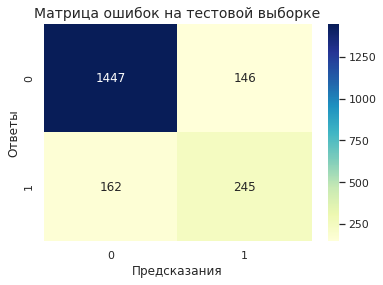

In [79]:
df_cm_forest_test = pd.DataFrame(confusion_matrix(target_test, predictions_forest_balanced_test))
sns.set(font_scale=1)
sns.heatmap(df_cm_forest_test, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок на тестовой выборке', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

Неплохо, но модель еще допускает ошибки, но главное, что их примерно поровну (FP, FN).

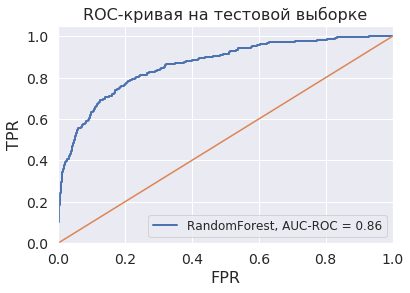

In [80]:
fpr, tpr, thresholds = roc_curve(target_test, rs_forest_balanced.predict_proba(features_test)[:,1], pos_label=1)
auc_forest_test = roc_auc_score(target_test, rs_forest_balanced.predict_proba(features_test)[:,1])
lw=2
plt.plot(fpr, tpr, lw=lw, label= 'RandomForest, AUC-ROC = %.2f' %auc_forest_test)

plt.title('ROC-кривая на тестовой выборке', fontsize=16)
plt.legend(loc='lower right', prop={'size':12})
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

На тестовой выборке лучшая модель показала хороший результат. Удалось достичь требуемой метрики F1. Кроме того, accuracy и AUC-ROC получились высокими, а также соблюден баланс между точностью и полнотой. Для нашей бизнес-задачи важно как не упустить клиента, который хочет уйти, так и не принять остающегося клиента за уходящего. Теперь, когда мы представляем, какие клиенты действительно могут уйти, нужно работать с ними: предложить скидку на обслуживание, более лояльные условия по кредиту или кредитной карте. Но если раздавать скидки направо и налево всем клиентам, даже тем, кто не собирается уходить, банк может нести убытки. Потому в данной задаче так важен баланс точности и полноты, и наша модель поставленной задаче удовлетворяет.